#### importando libs

In [1]:
import pickle
import numpy as np

#### lendo arquivo de treino

In [2]:
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

#### avaliando dataset

In [3]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

#### historia

In [4]:
" ".join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

#### question

In [5]:
" ".join(train_data[0][1])

'Is Sandra in the hallway ?'

#### answer

In [6]:
" ".join(train_data[0][2])

'n o'

#### garantindo que os dados de teste não fiquem na base de treino

In [7]:
all_data = test_data +train_data

In [8]:
len(all_data)

11000

In [9]:
lista_vocab = set()

for story, question, answer in all_data:
    lista_vocab = lista_vocab.union(set(story))
    lista_vocab = lista_vocab.union(set(question))

In [10]:
vocab_len = len(lista_vocab)+1

In [11]:
lista_vocab.add('no')
lista_vocab.add('yes')

#### adicionando sim e não na lista de vocabulário

lista_vocab.add('no')
lista_vocab.add('yes')

In [12]:
vocab_len

36

In [13]:
import numpy as np

#### encontrando os maiores comprimentos de cada tipo de texto:  -historia, questão, resposta

In [14]:
max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])
max_answer_len = max([len(data[2]) for data in all_data])

#### iniciando etapa de vetorização dos dados

In [15]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(lista_vocab)

In [17]:
tokenizer.word_index

{'garden': 1,
 'left': 2,
 'yes': 3,
 'took': 4,
 'put': 5,
 'got': 6,
 'to': 7,
 'football': 8,
 'up': 9,
 'picked': 10,
 'down': 11,
 'dropped': 12,
 'milk': 13,
 'travelled': 14,
 '.': 15,
 'hallway': 16,
 '?': 17,
 'there': 18,
 'back': 19,
 'no': 20,
 'office': 21,
 'bedroom': 22,
 'grabbed': 23,
 'daniel': 24,
 'is': 25,
 'went': 26,
 'sandra': 27,
 'the': 28,
 'journeyed': 29,
 'john': 30,
 'bathroom': 31,
 'discarded': 32,
 'kitchen': 33,
 'in': 34,
 'moved': 35,
 'mary': 36,
 'apple': 37}

#### realizando tokenização para as perguntas e respostas

In [18]:
train_story_text = list()
train_question_text = list()
train_answers = list()

for story, question, answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

#### tokenizando as listas

In [19]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

#### função para criar os vetores de treino e teste

In [20]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len, max_question_len= max_question_len):
    X=list() #historias
    Xq =list() #questoes
    Y = list() #respostas
    
    #capturando os indices das palavras e inserindo nas listas
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        
        y = np.zeros(len(word_index)+1)

        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    
    return (pad_sequences(X,maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))
        

#### criando bases de treino e teste

In [21]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

#### realizando a criação do modelo

In [22]:
from tensorflow.keras.models import Sequential,Model

In [23]:
from keras.layers.embeddings import Embedding

In [24]:
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

#### definindo parâmetros de entrada da rede

In [25]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [26]:
vocab_size = len(lista_vocab)+1

#### criando as entradas do encoder M

In [27]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#### criando as entradas do encoder C

In [28]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))


#### criando o encoder de question

In [29]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64, input_length=max_question_len) )
input_encoder_m.add(Dropout(0.3))

#### criando o codificador
#### encoded é igual ao enconder(input)

In [30]:
input_encoded_m=input_encoder_m(input_sequence)
input_encoded_c=input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

#### usando o produto de um ponto para calcular a correspondência entre a primeira sequencia do vetor de entrada

In [31]:
match = dot([input_encoded_m, question_encoded], axes=(2,2))
match=Activation('softmax')(match)

#### usando o produto de um ponto para calcular a correspondência entre a segunda sequencia do vetor de entrada

In [32]:
response = add([match, input_encoded_c])
response = Permute((2,1))(response)

In [33]:
answer = concatenate([response, question_encoded])

In [34]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

#### reduzindo o vetor para uma rede neural

In [35]:
answer = LSTM(32)(answer)

#### série de regularização com abandono

In [36]:
answer= Dropout(0.5)(answer)
answer=Dense(vocab_size)(answer) #YES/NO

#### gerando uma distribuição de probabilidade sobre o vocabulário

In [37]:
answer=Activation('softmax')(answer)

In [38]:
model = Model([input_sequence, question], answer)

In [39]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### gerando um resumo do modelo gerado

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 38,730
Trainable params: 38,730
Non-trainable params: 0
__________________________________________________________________________________________________


#### fitando o modelo e avaliando processamento através das épocas

In [41]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=10, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/10
313/313 [==============================] - 5s 9ms/step - loss: 0.7955 - accuracy: 0.4939 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 2/10
313/313 [==============================] - 2s 7ms/step - loss: 0.6953 - accuracy: 0.4988 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 3/10
313/313 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.4978 - val_loss: 0.6953 - val_accuracy: 0.4970
Epoch 4/10
313/313 [==============================] - 2s 7ms/step - loss: 0.6950 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4830
Epoch 5/10
313/313 [==============================] - 2s 7ms/step - loss: 0.6942 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4880
Epoch 6/10
313/313 [==============================] - 2s 7ms/step - loss: 0.6925 - accuracy: 0.5142 - val_loss: 0.6898 - val_accuracy: 0.5460
Epoch 7/10
313/313 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.61 - 2s 7ms/step - loss: 0.6601 - accuracy: 0.6196 - val_

#### função para avaliar a quantidade de época que o modelo performa bem 

In [42]:
history.history

{'loss': [0.7955331802368164,
  0.6952540278434753,
  0.6949746608734131,
  0.6949748992919922,
  0.6942086815834045,
  0.6925251483917236,
  0.6601150631904602,
  0.5148060321807861,
  0.3977937400341034,
  0.3561357259750366],
 'accuracy': [0.49390000104904175,
  0.49880000948905945,
  0.49779999256134033,
  0.5019000172615051,
  0.5022000074386597,
  0.51419997215271,
  0.6195999979972839,
  0.7771999835968018,
  0.8328999876976013,
  0.8521999716758728],
 'val_loss': [0.693755567073822,
  0.693294107913971,
  0.6953368782997131,
  0.6932446956634521,
  0.6931442022323608,
  0.6898294687271118,
  0.6174739599227905,
  0.45576852560043335,
  0.4454246163368225,
  0.38831934332847595],
 'val_accuracy': [0.4970000088214874,
  0.503000020980835,
  0.4970000088214874,
  0.4830000102519989,
  0.4880000054836273,
  0.5460000038146973,
  0.7120000123977661,
  0.796999990940094,
  0.8309999704360962,
  0.8360000252723694]}

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


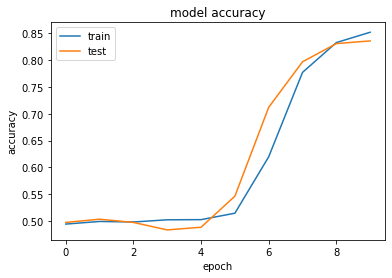

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Realizando predição do modelo

In [44]:
pred_results = model.predict([inputs_test, queries_test])

In [45]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

#### O vetor preditor, gera uma série de probabilidades para cada palavra do vocabulário

In [46]:
pred_results[0]

array([3.7727716e-08, 5.0404729e-08, 3.6008071e-08, 5.8910564e-02,
       4.3668944e-08, 4.2718092e-08, 4.2689418e-08, 3.0791409e-08,
       4.6931319e-08, 4.7346074e-08, 3.6182531e-08, 4.8926019e-08,
       3.9911235e-08, 4.3162157e-08, 3.8849596e-08, 2.8822807e-08,
       5.1974304e-08, 3.7694772e-08, 3.9772324e-08, 3.9657188e-08,
       9.4108796e-01, 3.4087403e-08, 3.7311441e-08, 4.1478092e-08,
       4.4416058e-08, 3.1490778e-08, 3.1853535e-08, 3.3277008e-08,
       3.3216448e-08, 3.4663849e-08, 3.6620001e-08, 3.8004334e-08,
       4.3839687e-08, 3.3894203e-08, 3.5128689e-08, 2.5174151e-08,
       4.4670937e-08, 3.9619383e-08], dtype=float32)

#### descobrindo a palavra predita

In [47]:
val_max = np.argmax(pred_results[0])

In [48]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key
print(k)

no


#### Avaliando a probabilidade

In [49]:
pred_results[0][val_max]

0.94108796

#### Testando o modelo com uma historia aleatória

In [50]:
my_story = "John left the kitchen .  Sandra dropped the football in the garden ."

In [51]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [52]:
my_question = "Is the football in the garden ?"

#### criando a base de dados da historia

In [53]:
mydata = [(my_story.split(), my_question.split(), 'yes')]

In [54]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

#### vetorizando textos

In [55]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

#### Realizando predição

In [56]:
pred_results = model.predict([my_story, my_ques])

In [57]:
val_max = np.argmax(pred_results[0])

In [58]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key
print(k)

yes


In [59]:
pred_results[0][val_max]

0.96772844